In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# We're using scikit so load in all the required dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [5]:
# Load in the .csv files
data_dir = "input/gmsc"
train = pd.read_csv(f"{data_dir}/cs-training.csv")
test = pd.read_csv(f"{data_dir}/cs-test.csv")
submission = pd.read_csv(f"{data_dir}/sampleEntry.csv")

In [7]:
# Shows the shape and info of the dataframe 
print("shape of dataframe is : ", train.shape)
train.info()

shape of dataframe is :  (150000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNo

In [8]:
# Rename the first column "Unnamed" to be "ID"
data = [train, test]
for df in data:
    df.rename(columns = {'Unnamed: 0': 'ID'}, inplace=True)

In [9]:
# Replace the null values to round out the training dataframe
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(), inplace=True)
train['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0], inplace=True)

train.isnull().sum()

/var/folders/g5/pq1216cd2x310s210s2jx33w0000gn/T/ipykernel_94591/3663733125.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(), inplace=True)
/var/folders/g5/pq1216cd2x310s210s2jx33w0000gn/T/ipykernel_94591/3663733125.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

ID                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [10]:
# Replace the null values to round out the test dataframe
test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(), inplace=True)
test['NumberOfDependents'].fillna(test['NumberOfDependents'].mode()[0], inplace=True)

test.isnull().sum()

/var/folders/g5/pq1216cd2x310s210s2jx33w0000gn/T/ipykernel_94591/1007495850.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(), inplace=True)
/var/folders/g5/pq1216cd2x310s210s2jx33w0000gn/T/ipykernel_94591/1007495850.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

ID                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [11]:
# Drop the columns we don't need from our features and set our label
X = train.drop(['ID', 'SeriousDlqin2yrs'], axis=1)
y = train['SeriousDlqin2yrs']

X_test = test.drop(['ID', 'SeriousDlqin2yrs'], axis=1)
y_test = test['SeriousDlqin2yrs']

In [12]:
# Transform our numerical columns for training and test data
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scale = StandardScaler()
scale.fit(X[num_columns])
X[num_columns] = scale.transform(X[num_columns]).copy()              # Create a copy of the dataframe with the scaled numerical columns
X_test[num_columns] = scale.transform((X_test[num_columns])).copy()

In [13]:
# Normalise our labels to be between 0 and 1
y.value_counts(normalize=True)
y_test.value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [22]:
# Define our decision tree classifier. Using 10 nodes (to keep the model small) as it predicts well without 
# TODO: Also train a 100-leaf decision tree and compare the two
model = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
model.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)

In [23]:
# Define Stratified sampling for out data i.e. 10-fold cross-validation
cv = StratifiedKFold(n_splits= 10, shuffle= True, random_state=13)
roc_auc_scores = cross_val_score(model, X, y, scoring= 'roc_auc', cv=cv, n_jobs = -1)
roc_auc_scores.mean()

0.8466924624733844

In [24]:
# Obtain our predictions
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)[:,1]   # Predictions on the training data
y_test_pred_proba = model.predict_proba(X_test)[:,1]

In [25]:
# roc_aoc_score for our predictions
roc_auc_score(y, y_pred_proba)

0.8518966672477497

In [26]:
# Plot the roc curve
def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

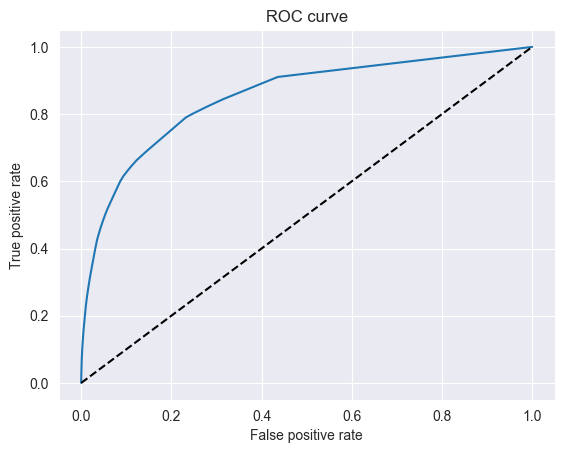

In [27]:
plot_roc(y, y_pred_proba)

In [28]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    139974
           1       0.62      0.22      0.32     10026

    accuracy                           0.94    150000
   macro avg       0.78      0.60      0.64    150000
weighted avg       0.92      0.94      0.92    150000


[Text(0.4916871921182266, 0.96875, 'NumberOfTimes90DaysLate <= 0.056\ngini = 0.125\nsamples = 150000\nvalue = [139974, 10026]\nclass = y[0]'),
 Text(0.22844827586206898, 0.90625, 'RevolvingUtilizationOfUnsecuredLines <= -0.022\ngini = 0.088\nsamples = 141662\nvalue = [135108, 6554]\nclass = y[0]'),
 Text(0.0960591133004926, 0.84375, 'NumberOfTime30-59DaysPastDueNotWorse <= 0.019\ngini = 0.05\nsamples = 112818\nvalue = [109944, 2874]\nclass = y[0]'),
 Text(0.04926108374384237, 0.78125, 'NumberOfTime60-89DaysPastDueNotWorse <= 0.062\ngini = 0.035\nsamples = 100612\nvalue = [98794.0, 1818.0]\nclass = y[0]'),
 Text(0.029556650246305417, 0.71875, 'RevolvingUtilizationOfUnsecuredLines <= -0.023\ngini = 0.033\nsamples = 99195\nvalue = [97547, 1648]\nclass = y[0]'),
 Text(0.019704433497536946, 0.65625, 'NumberRealEstateLoansOrLines <= 2.197\ngini = 0.024\nsamples = 81652\nvalue = [80665, 987]\nclass = y[0]'),
 Text(0.009852216748768473, 0.59375, 'gini = 0.022\nsamples = 79848\nvalue = [78952, 

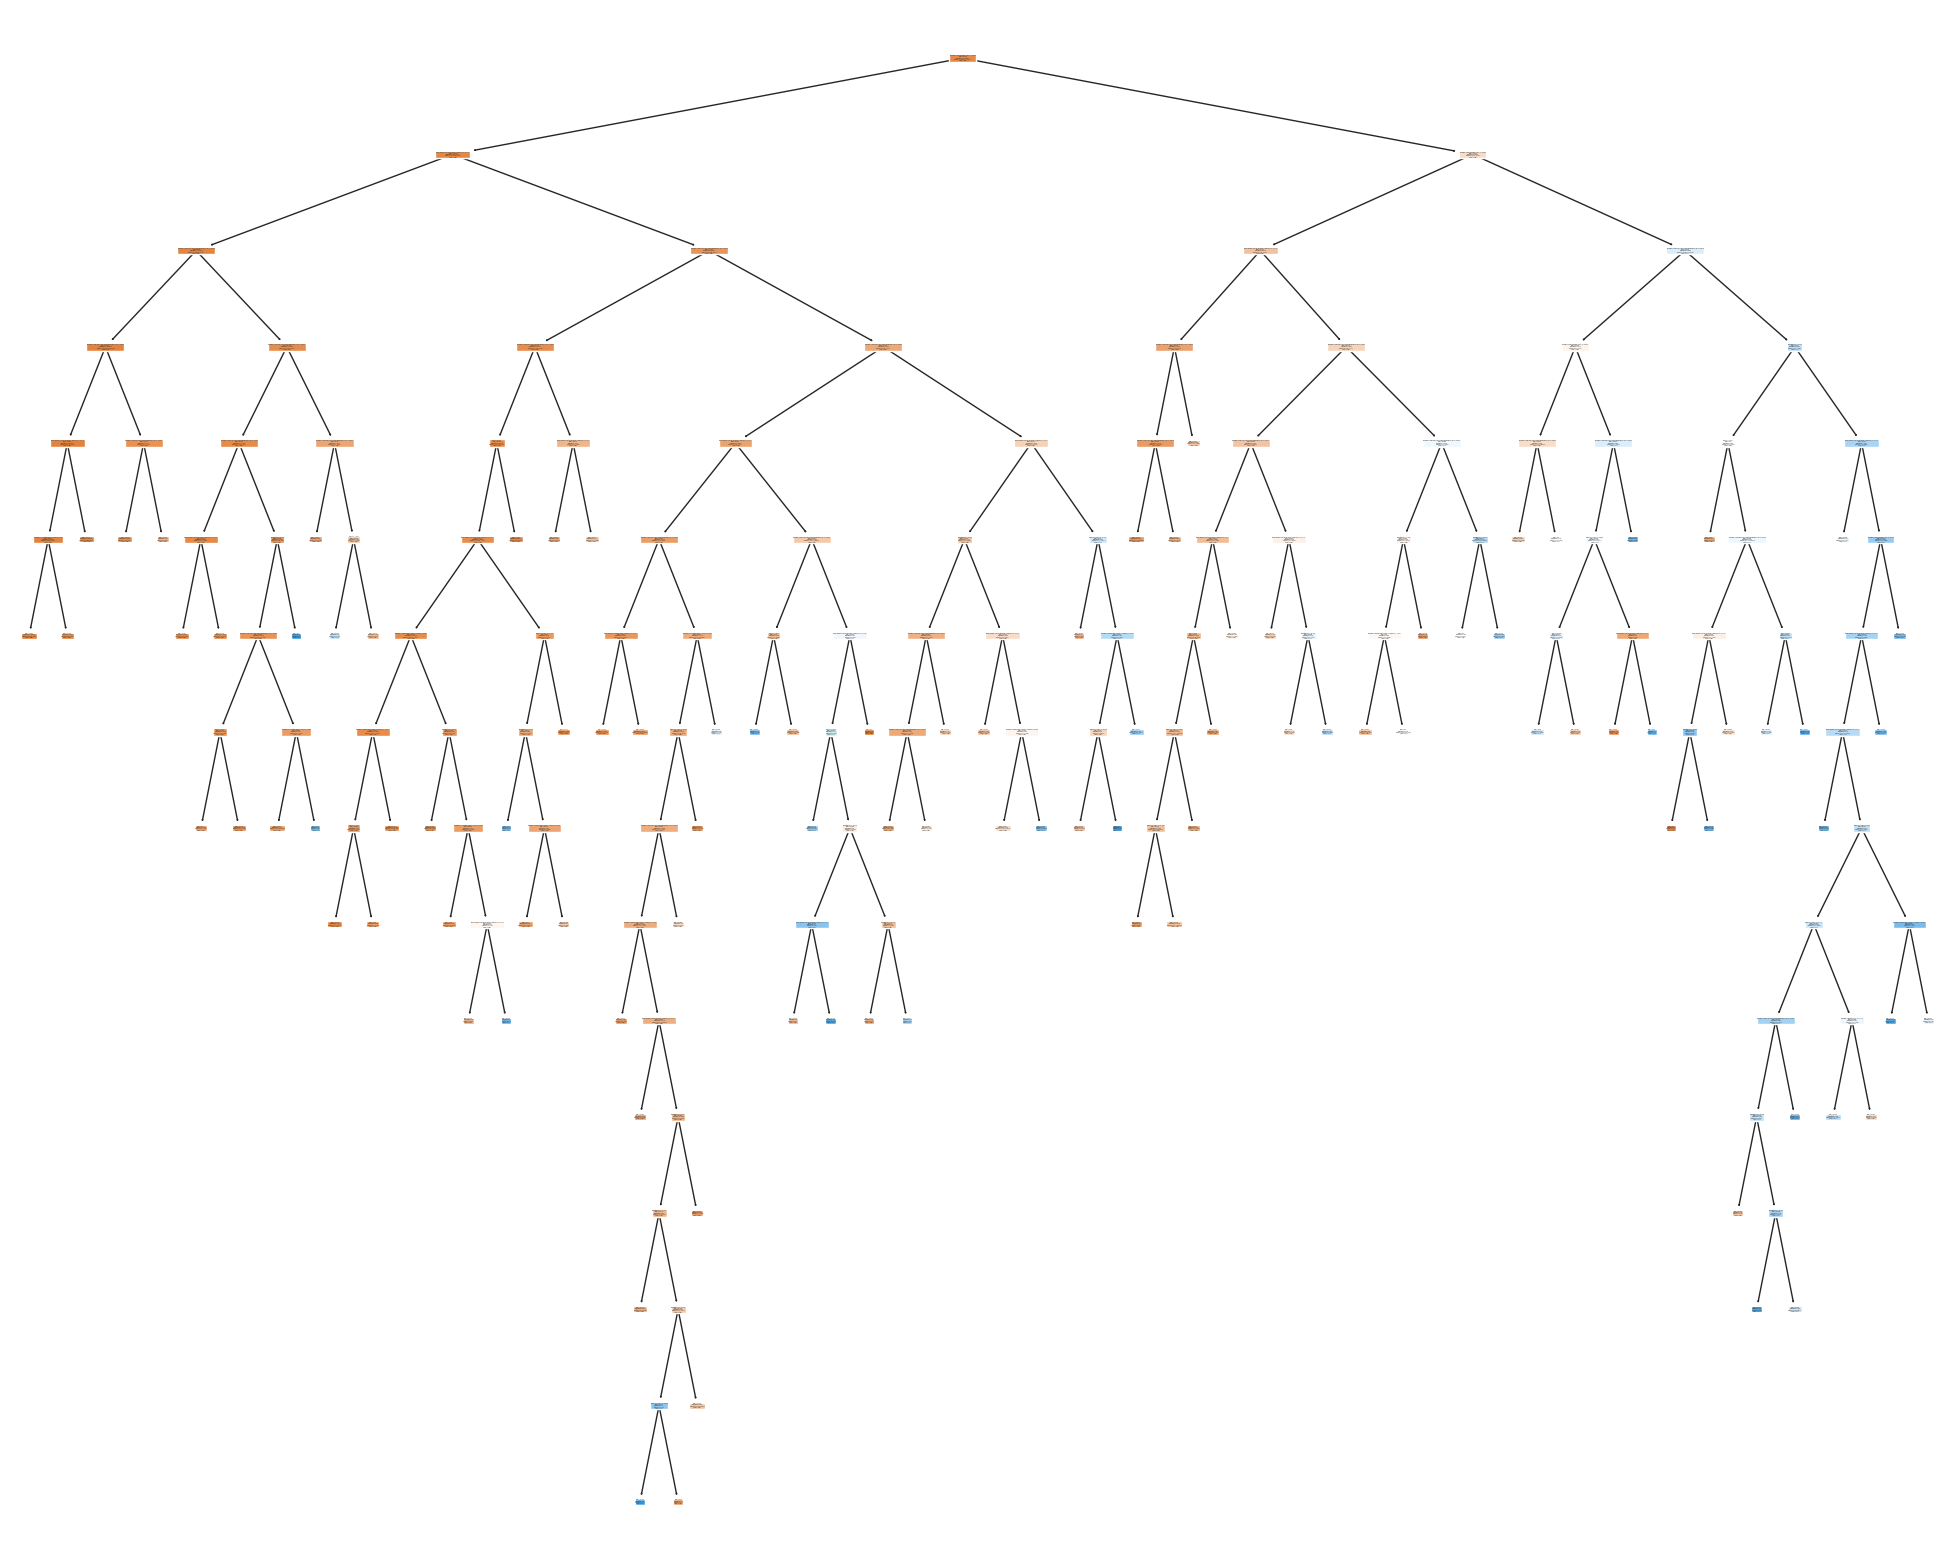

In [29]:
# Display our decision tree
from sklearn import tree
fig = plt.figure(figsize=(25,20))
# tree.plot_tree(model)

tree.plot_tree(model,
    feature_names=X.columns,
    class_names=True,
    filled=True)
